## Egg Price Analysis

### Setup and Data Loading

In [140]:
import pandas as pd
from sqlalchemy import create_engine
import os
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Configurations matching docker
DB_CONFIG = {
    'user': os.getenv('DB_USER', 'egg_user'),
    'password': os.getenv('DB_PASSWORD', 'egg_pass'),
    'host': os.getenv('DB_HOST', 'localhost'),
    'port': os.getenv('DB_PORT', 5432),
    'database': os.getenv('DB_NAME', 'egg_prices')
}

# Clean connection string
conn_string = (
    f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}"
    f"@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
)

# Creating Dataframe and CSV file for analysis
engine = create_engine(conn_string)
df = pd.read_sql("SELECT * FROM economic_data", engine)
df.to_csv('data/egg_price_drivers.csv')

In [141]:
df.head()

,date,flu_outbreak_count,flu_birds_affected,egg_price,corn_price,month,quarter,egg_price_lag,flu_lag
0,2019-01-01,0.0,0.0,1.554,166.846241,1,1,NaN,NaN
1,2019-02-01,0.0,0.0,1.557,169.656283,2,1,1.554,0.0
2,2019-03-01,0.0,0.0,1.544,166.321332,3,1,1.557,0.0
3,2019-04-01,0.0,0.0,1.463,161.653387,4,2,1.544,0.0
4,2019-05-01,0.0,0.0,1.362,171.180154,5,2,1.463,0.0


### Statistical Validation 

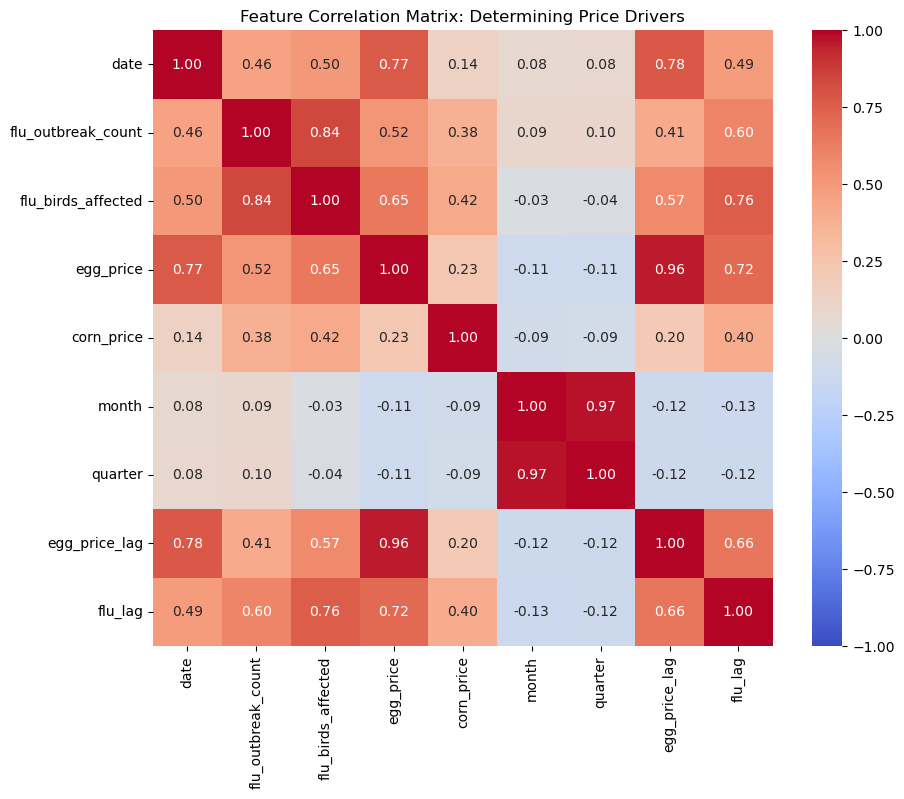

In [142]:
eda_df = df.dropna() # drop first row from shift

# Plot Correlation Matrix 
corr_matrix = eda_df.corr()

fig = plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            vmin=-1, vmax=1)

plt.title('Feature Correlation Matrix: Determining Price Drivers')
plt.savefig('images/eda/egg_price_correlation_matrix.png')


In [187]:
# Creating additional lags to match egg price change difference
df['egg_diff'] = df['egg_price'].diff()
df['egg_diff_lag'] = df['egg_diff'].shift(1) 

df['corn_diff'] = df['corn_price'].diff()
df['corn_diff_lag'] = df['corn_diff'].shift(1)

df['flu_panic_lag'] = df['flu_outbreak_count'].shift(1)

df = df.dropna()

df.head()

,date,flu_outbreak_count,flu_birds_affected,egg_price,corn_price,month,quarter,egg_price_lag,flu_lag,egg_diff,egg_diff_lag,corn_diff,corn_diff_lag,flu_panic_lag
4,2019-05-01,0.0,0.0,1.362,171.180154,5,2,1.463,0.0,-0.101,-0.081,9.526767,-4.667945,0.0
5,2019-06-01,0.0,0.0,1.203,195.167922,6,2,1.362,0.0,-0.159,-0.101,23.987769,9.526767,0.0
6,2019-07-01,0.0,0.0,1.243,189.486373,7,3,1.203,0.0,0.040,-0.159,-5.681549,23.987769,0.0
7,2019-08-01,0.0,0.0,1.219,163.628614,8,3,1.243,0.0,-0.024,0.040,-25.857759,-5.681549,0.0
8,2019-09-01,0.0,0.0,1.383,157.374437,9,3,1.219,0.0,0.164,-0.024,-6.254178,-25.857759,0.0


In [ ]:
# Plot Correlation Matrix 
corr_matrix = df.corr()

fig = plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            vmin=-1, vmax=1)

plt.title('Feature Correlation Matrix: Determining Price Drivers')
plt.savefig('images/eda/price_diff_correlation_matrix.png')

### Modeling 

In [188]:
df = df.set_index('date') # csv reads date as an index

features = ['egg_diff_lag', 'corn_diff_lag', 'flu_panic_lag']

X = df[features]
y = df['egg_diff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

lr = LinearRegression()
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)

lr_mae = mean_absolute_error(y_test, lr_preds)

print(f"Baseline (Linear Regression) MAE: {lr_mae:.3f}")

# 3. Train Challenger
xgb_model = XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1,   
    max_depth=1,  
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict
xgb_preds = xgb_model.predict(X_test)

# Evaluate
xgb_mae = mean_absolute_error(y_test, xgb_preds)
print(f"Challenger (XGBoost) MAE: {xgb_mae:.4f}")

Baseline (Linear Regression) MAE: 0.381
Challenger (XGBoost) MAE: 0.4069


### Performance Visualization

In [189]:
# Actual vs Predicted
actual_vs_pred_df = pd.DataFrame ({
    'date' : y_test.index,
    'Actual' : y_test.values,
    'Linear Regression' : lr_preds,
    'XGBoost' : xgb_preds 
})

# Reshape to long format for Tableau
actual_vs_pred_long = actual_vs_pred_df.melt(
    id_vars=['date'], # unchanged
    value_vars=['Actual', 'Linear Regression', 'XGBoost'], # unpivot
    var_name='model', # new column
    value_name='price_change' # name for new values in new column
)

actual_vs_pred_long.to_csv('data/outputs/tableau_predictions.csv', index=False)


# Residuals
residuals_df = pd.DataFrame({
    'date': y_test.index,
    'actual' : y_test.values,
    'Linear Regression' : lr_preds,
    'XGBoost' : xgb_preds,
    'Linear Regression Residuals': y_test.values - lr_preds,
    'XGBoost Residuals' : y_test.values - xgb_preds
})

residuals_long = residuals_df.melt(
    id_vars='date',
    value_vars=['Linear Regression Residuals', 'XGBoost Residuals'],
    var_name='model',
    value_name='residual'
)

residuals_long.to_csv('data/outputs/tableau_residuals.csv', index=False)

# Feature Importance

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'Feature' : features,
    'importance' : xgb_model.feature_importances_,
    'model' : 'XGBoost'
})

# Linear Regression Coefficients (absolute values)
lr_importance = pd.DataFrame({
    'feature' : features,
    'importance' : abs(lr.coef_),
    'model' : 'Linear Regression'
})

feature_importance = pd.concat([xgb_importance, lr_importance], ignore_index=True)

feature_importance = feature_importance.sort_values(['model', 'importance'], ascending=[True,False])

feature_importance.to_csv('data/outputs/tableau_feature_importance.csv', index=False)